In [1]:
import os
import re
import time
import math
import json

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from skimage.transform import resize

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [2]:
concrete = plt.imread("image1.jpg")
shape = concrete.shape
concrete = resize(concrete, (shape[0]//2, shape[1]//2))
#concrete = np.dot(concrete[... , :3], [.21, .72, .07])

size = 224
shape = concrete.shape
height, width = shape[0]//size, shape[1]//size

#fig, ax = plt.subplots(height, width, figsize=(width//2, height//2))
#ax = ax.flatten(); [ax.set_axis_off() for ax in ax]
imozaic = np.array([
    concrete[y*size:y*size+size,x*size:x*size+size]
     for y in range(height)
      for x in range(width)
]).reshape(height, width, 224, 224, 3)

imozaic = np.einsum("HWXYC->HWCXY", imozaic)

#for i, im in enumerate(imozaic): ax[i].imshow(im)

In [3]:
class CrackClassifier(nn.Module):
    def __init__(self):
        super(CrackClassifier, self).__init__()
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        
        return x
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block

In [4]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## ENCODER
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## DECODER
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

In [5]:
bi_model = CrackClassifier()
bi_model.load_state_dict(torch.load(f"models/crack_binary_c_xx.torch"))
bi_model.eval()
bi_model.double()

CrackClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [6]:
mask_model = ConvAutoencoder()
mask_model.load_state_dict(torch.load(f"models/crack_mask_c_90.torch"))
mask_model.eval()
mask_model.double()

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [7]:
binary = []
for row in imozaic:
    tensor = torch.from_numpy(row)
    binary.append(torch.max(bi_model(tensor), 1)[1].numpy().flatten())

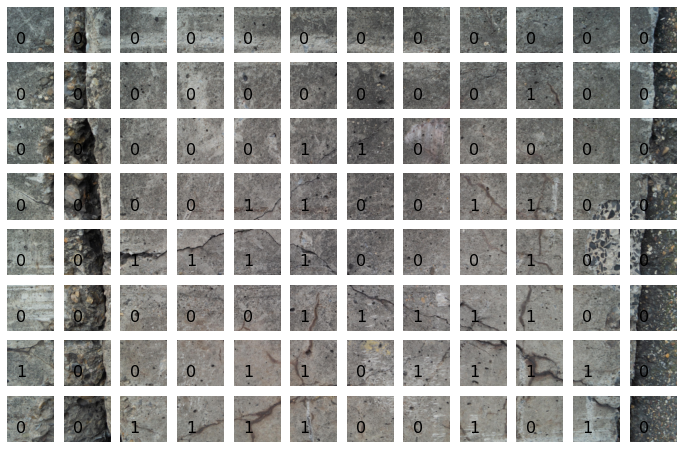

In [26]:
fig, ax = plt.subplots(height, width, figsize=(width, height))
for y in range(height):
    for x in range(width):
        ax[y][x].set_axis_off()
        ax[y][x].imshow(np.einsum("CXY->XYC", imozaic[y][x]))
        ax[y][x].text(0.2,0.2,s=labels[y][x], fontsize=16, transform=ax[y][x].transAxes)

In [30]:
image1_labels = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,1,0,0,],
    [0,0,0,0,0,1,1,0,0,0,0,0,],
    [0,0,0,0,1,1,0,0,1,1,0,0,],
    [0,0,1,1,1,1,0,0,0,1,0,0,],
    [0,0,0,0,0,1,1,1,1,1,0,0,],
    [1,0,0,0,1,1,0,1,1,1,1,0,],
    [0,0,1,1,1,1,0,0,1,0,1,0,],
])

In [29]:
labels.sum(), width*height

(30, 96)

In [29]:
tensors = torch.from_numpy(np.array(list(map(lambda m: np.array(m) ,imozaic))))

In [30]:
slices = list(zip(list(range(tensors.shape[0])[::16]), list(range(tensors.shape[0])[15::16])))

In [ ]:
tensor = tensors[:]

binary = []
for tensors.shape[0]
np.array(torch.max(bi_model(tensor), 1)[1])

In [ ]:
binary = [torch.max(bi_model(tensor.reshape(-1,*tensor.shape)), 1)[1] for tensor in tensors]

In [21]:
masks = list(map(lambda tensor: torch.detach(mask_model(tensor.reshape(-1,*tensor.shape))).numpy()[0], tensors))

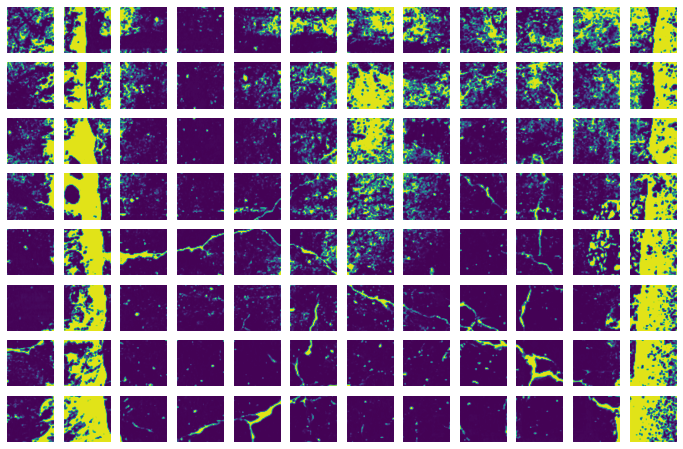

In [22]:
fig, ax = plt.subplots(height, width, figsize=(width, height))
ax = ax.flatten(); [ax.set_axis_off() for ax in ax]
for i, im in enumerate(masks): ax[i].imshow(im[0])